# Третья лабораторная работа

In [225]:
import pandas as pd

data = pd.read_csv('../data/mumbai_houses_task.csv')

In [226]:
data.head(10)

,price,area,latitude,longitude,Bedrooms,Bathrooms,Balcony,Status,neworold,parking,Furnished_status,Lift,type_of_building
0,22400000.0,629.0,19.032800,72.896357,2.0,2.0,0.0,Under Construction,New Property,0.0,NaN,0.0,Flat
1,35000000.0,974.0,19.032800,72.896357,3.0,2.0,0.0,Under Construction,New Property,0.0,NaN,0.0,Flat
2,31700000.0,968.0,19.085600,72.909277,3.0,3.0,0.0,Under Construction,New Property,0.0,NaN,0.0,Flat
3,18700000.0,629.0,19.155756,72.846862,2.0,2.0,2.0,Ready to Move,New Property,2.0,NaN,2.0,Flat
4,13500000.0,1090.0,19.177555,72.849887,2.0,2.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
5,13000000.0,630.0,19.148058,72.937725,2.0,2.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
6,20700000.0,1188.0,19.154919,72.843566,2.0,2.0,2.0,NaN,New Property,2.0,Semi-Furnished,2.0,Flat
7,22900000.0,968.0,19.147269,72.848351,3.0,3.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
8,17000000.0,820.0,19.015128,72.858064,2.0,2.0,0.0,NaN,New Property,0.0,Unfurnished,0.0,Flat
9,81000000.0,3260.0,19.001640,72.826532,3.0,3.0,3.0,Ready to Move,Resale,3.0,NaN,3.0,Flat


Опишем поля датасета:
- price - цена
- area - площадь дома/квартиры
- latitude/longitude - широта/долгота (в градусах)
- Bedrooms - кол-во спален
- Balcony - кол-во балконов
- Status - статус дома/квартиры (строящийся/готовый к заселению)
- neworold - новое или старое (новое/перепродажа)
- parking - кол-во парковочных мест на дом/квартиру
- Furnished_status - статус "омеблериванности" (Полу-меблированный, немеблированный, меблированный)
- Lift - кол-во лифтов в помещении
- type_of_building - тип здания: дом/квартира


In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             6255 non-null   float64
 1   area              6255 non-null   float64
 2   latitude          6255 non-null   float64
 3   longitude         6255 non-null   float64
 4   Bedrooms          6255 non-null   float64
 5   Bathrooms         6255 non-null   float64
 6   Balcony           6255 non-null   float64
 7   Status            5774 non-null   object 
 8   neworold          6255 non-null   object 
 9   parking           6255 non-null   float64
 10  Furnished_status  3600 non-null   object 
 11  Lift              6255 non-null   float64
 12  type_of_building  6255 non-null   object 
dtypes: float64(9), object(4)
memory usage: 635.4+ KB


# Предобработка данных

## *Меняем имена столбцов*

In [228]:
data.columns

Index(['price', 'area', 'latitude', 'longitude', 'Bedrooms', 'Bathrooms',
       'Balcony', 'Status', 'neworold', 'parking', 'Furnished_status', 'Lift',
       'type_of_building'],
      dtype='object')

In [229]:
data = data.rename(
    columns = {x: '_'.join(x.lower().split()) for x in data.columns}
)
data.columns

Index(['price', 'area', 'latitude', 'longitude', 'bedrooms', 'bathrooms',
       'balcony', 'status', 'neworold', 'parking', 'furnished_status', 'lift',
       'type_of_building'],
      dtype='object')

## *Заполняем пропущенные значения*

In [230]:
data.isna().sum().sort_values(ascending=False)

furnished_status    2655
status               481
price                  0
area                   0
latitude               0
longitude              0
bedrooms               0
bathrooms              0
balcony                0
neworold               0
parking                0
lift                   0
type_of_building       0
dtype: int64

Можно предположить, если при написании объявления не упомянули каку-либо мебель, значит её и не имели в виду, то есть её не будет. Потому большое кол-во пропущенных значений поля furnished_status имеет смысл заполнить как "Unfurnished"

In [231]:
data["furnished_status"] = data["furnished_status"].fillna("Unfurnished")
data["furnished_status"].isna().sum()

0

Аналогично и с полем статуса дома/квартиры: если бы он не был готов к заселению, в объявлении 100% это указали бы, следовательно, имеет смысл заполнить все пропуски домами, готовыми к заселению: "Ready to Move"

In [232]:
data["status"] = data["status"].fillna("Ready to Move")
data.isna().sum()

price               0
area                0
latitude            0
longitude           0
bedrooms            0
bathrooms           0
balcony             0
status              0
neworold            0
parking             0
furnished_status    0
lift                0
type_of_building    0
dtype: int64

### Проверяем наличие/избавляемся дубликатов

In [233]:
data.duplicated().sum()

18

In [234]:
data = data.drop_duplicates().reset_index(drop= True)

In [235]:
data.duplicated().sum()

0

## Корректируем тип данных столбцов

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             6237 non-null   float64
 1   area              6237 non-null   float64
 2   latitude          6237 non-null   float64
 3   longitude         6237 non-null   float64
 4   bedrooms          6237 non-null   float64
 5   bathrooms         6237 non-null   float64
 6   balcony           6237 non-null   float64
 7   status            6237 non-null   object 
 8   neworold          6237 non-null   object 
 9   parking           6237 non-null   float64
 10  furnished_status  6237 non-null   object 
 11  lift              6237 non-null   float64
 12  type_of_building  6237 non-null   object 
dtypes: float64(9), object(4)
memory usage: 633.6+ KB


In [237]:
data.head(10)

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift,type_of_building
0,22400000.0,629.0,19.032800,72.896357,2.0,2.0,0.0,Under Construction,New Property,0.0,Unfurnished,0.0,Flat
1,35000000.0,974.0,19.032800,72.896357,3.0,2.0,0.0,Under Construction,New Property,0.0,Unfurnished,0.0,Flat
2,31700000.0,968.0,19.085600,72.909277,3.0,3.0,0.0,Under Construction,New Property,0.0,Unfurnished,0.0,Flat
3,18700000.0,629.0,19.155756,72.846862,2.0,2.0,2.0,Ready to Move,New Property,2.0,Unfurnished,2.0,Flat
4,13500000.0,1090.0,19.177555,72.849887,2.0,2.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
5,13000000.0,630.0,19.148058,72.937725,2.0,2.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
6,20700000.0,1188.0,19.154919,72.843566,2.0,2.0,2.0,Ready to Move,New Property,2.0,Semi-Furnished,2.0,Flat
7,22900000.0,968.0,19.147269,72.848351,3.0,3.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
8,17000000.0,820.0,19.015128,72.858064,2.0,2.0,0.0,Ready to Move,New Property,0.0,Unfurnished,0.0,Flat
9,81000000.0,3260.0,19.001640,72.826532,3.0,3.0,3.0,Ready to Move,Resale,3.0,Unfurnished,3.0,Flat


In [238]:
data["status"].unique()

array(['Under Construction', 'Ready to Move'], dtype=object)

Поскольку neworold, status принимают два разных значения, потому заменим на тип bool. 
Количественные столбцы имеет смысл заменить на int: bedrooms, bathrooms, balcony, parking, lift.

Так как нам дальше в задачи линейной регрессии нужны будут только признаки с числовым типом данных, заменим значения поля furnished_status: Furnished, Unfurnished, Semi-furnished на 1,0 и 0.5 соответственно. 

In [239]:
float_to_int = {"bedrooms", "bathrooms", "balcony", "parking", "lift"}
for field in float_to_int: 
    data[field] = data[field].astype(int)

In [240]:
dict_neworold = {"New Property": True, "Resale": False}
data["neworold"] = data["neworold"].map(dict_neworold)

dict_status = {"Ready to Move": True, "Under Construction": False}
data["status"] = data["status"].map(dict_status)

dict_furnished = {"Semi-Furnished": 0.5, "Furnished": 1, "Unfurnished": 0}
data["furnished_status"] = data["furnished_status"].map(dict_furnished)


In [241]:
# to_bool = {"neworold", "status"}
# for field in to_bool: data[field] = data[field].astype(bool)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             6237 non-null   float64
 1   area              6237 non-null   float64
 2   latitude          6237 non-null   float64
 3   longitude         6237 non-null   float64
 4   bedrooms          6237 non-null   int64  
 5   bathrooms         6237 non-null   int64  
 6   balcony           6237 non-null   int64  
 7   status            6237 non-null   bool   
 8   neworold          6237 non-null   bool   
 9   parking           6237 non-null   int64  
 10  furnished_status  6237 non-null   float64
 11  lift              6237 non-null   int64  
 12  type_of_building  6237 non-null   object 
dtypes: bool(2), float64(5), int64(5), object(1)
memory usage: 548.3+ KB


# EDA

Основные параметры, влиящие на цену:
- area
- bedrooms
- bathrooms
- balcony
- parking
- lift

In [242]:
columns = ["price","area", "bedrooms", "bathrooms", "balcony","parking", "lift"]

data.describe()[columns]

,price,area,bedrooms,bathrooms,balcony,parking,lift
count,6.237000e+03,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000
mean,2.686215e+07,1185.597723,2.452301,2.425525,0.822350,0.822350,0.822350
std,2.792125e+07,637.515522,0.750140,0.763236,1.291977,1.291977,1.291977
min,1.500000e+06,503.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.300000e+07,846.000000,2.000000,2.000000,0.000000,0.000000,0.000000
50%,1.900000e+07,1000.000000,2.000000,2.000000,0.000000,0.000000,0.000000
75%,3.000000e+07,1300.000000,3.000000,3.000000,1.000000,1.000000,1.000000
max,3.600000e+08,8000.000000,10.000000,10.000000,8.000000,8.000000,8.000000


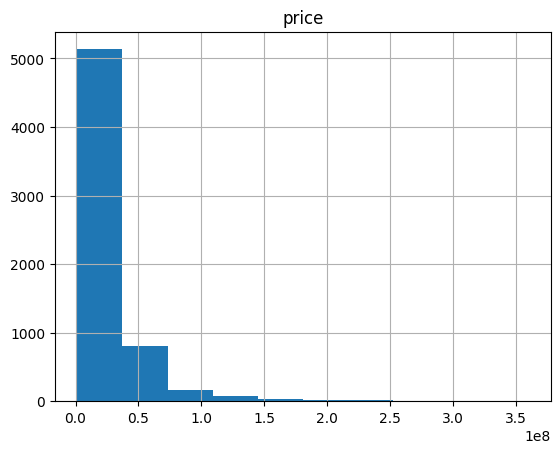

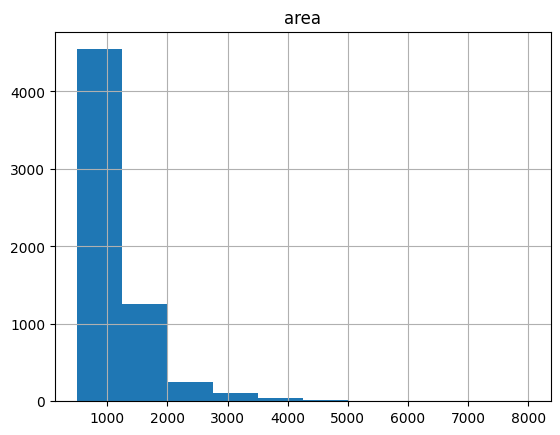

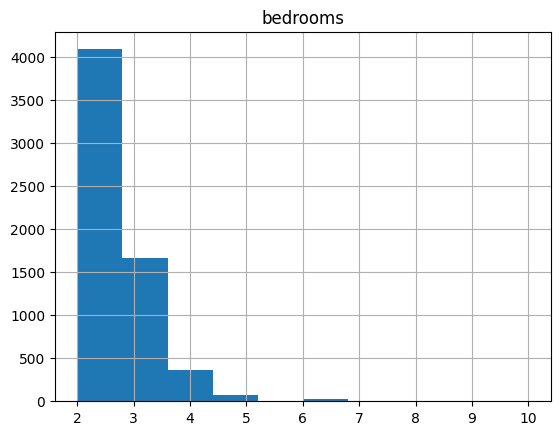

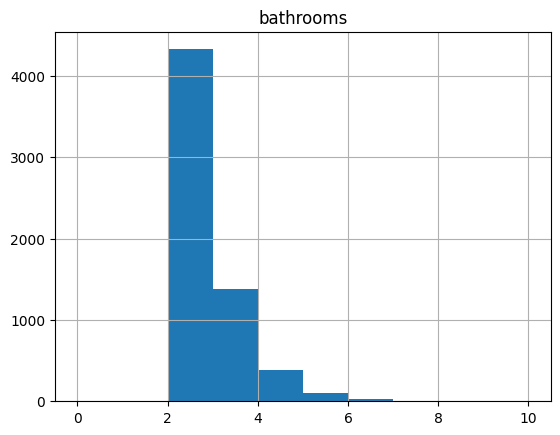

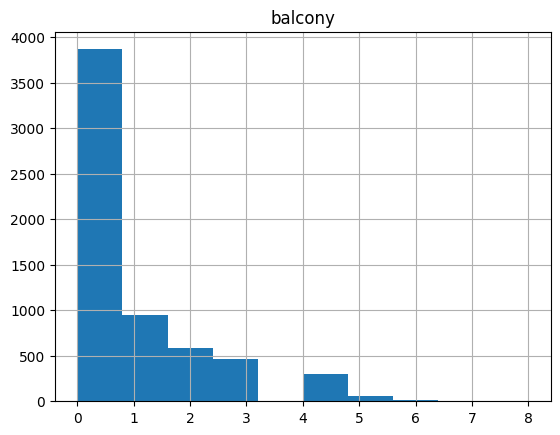

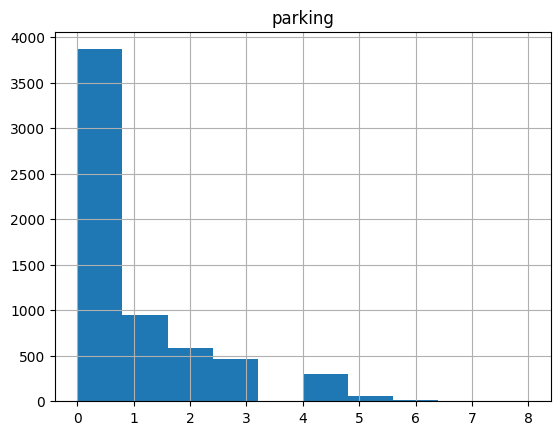

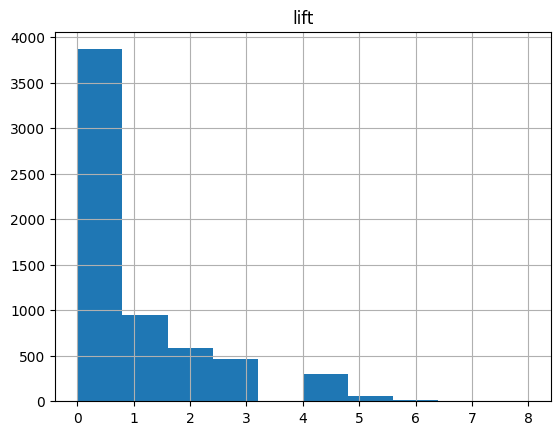

In [243]:
for column in columns: data.hist(column)

Нужно убрать аномальные значения у price, area, чтобы данные по графику было легче прочитать. У полей целочисленного типа уникальных значений не так много, следовательно, удалив выбросы, мы ещё уменьшим кол-во уникальных значений, потому это не целесообразно.

## Изучение и обработка выбросов

In [244]:
outliers = data[["price","area"]]
outliers

,price,area
0,22400000.0,629.0
1,35000000.0,974.0
2,31700000.0,968.0
3,18700000.0,629.0
4,13500000.0,1090.0
...,...,...
6232,19500000.0,810.0
6233,22000000.0,1400.0
6234,20000000.0,750.0
6235,11000000.0,700.0


In [245]:
# Определить нижние пределы для выбросов
Q1 = outliers.quantile(0.25)
Q1

price    13000000.0
area          846.0
Name: 0.25, dtype: float64

In [246]:
# Определить верхние пределы выбросов
Q3 = outliers.quantile(0.75)
Q3

price    30000000.0
area         1300.0
Name: 0.75, dtype: float64

In [247]:
# IQR-оценки
IQR = Q3-Q1
# Отфильтрованные данные, из которых удалены выбросы
data_filtered = outliers[~((outliers < (Q1 - 1.5 * IQR)) |(outliers > (Q3 + 1.5 * IQR))).any(axis=1)]
data_filtered

,price,area
0,22400000.0,629.0
1,35000000.0,974.0
2,31700000.0,968.0
3,18700000.0,629.0
4,13500000.0,1090.0
...,...,...
6232,19500000.0,810.0
6233,22000000.0,1400.0
6234,20000000.0,750.0
6235,11000000.0,700.0


In [248]:
# Копирование индексов
index_list = list(data_filtered.index.values)
# index_list

In [249]:
# Хранить данные без выбросов в отдельном DataFrame.
data_filtered = data[data.index.isin(index_list)]
data_filtered.head()

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift,type_of_building
0,22400000.0,629.0,19.032800,72.896357,2,2,0,False,True,0,0.0,0,Flat
1,35000000.0,974.0,19.032800,72.896357,3,2,0,False,True,0,0.0,0,Flat
2,31700000.0,968.0,19.085600,72.909277,3,3,0,False,True,0,0.0,0,Flat
3,18700000.0,629.0,19.155756,72.846862,2,2,2,True,True,2,0.0,2,Flat
4,13500000.0,1090.0,19.177555,72.849887,2,2,0,True,True,0,0.0,0,Flat


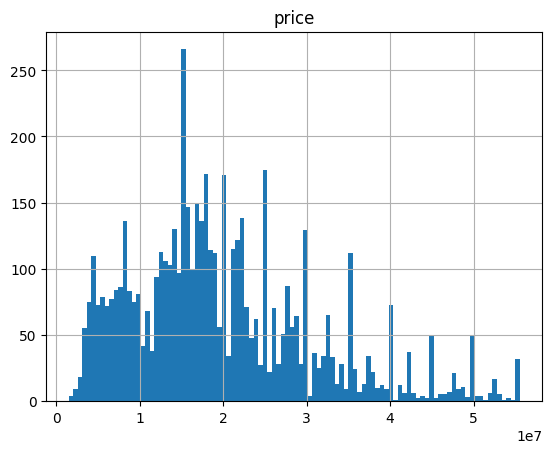

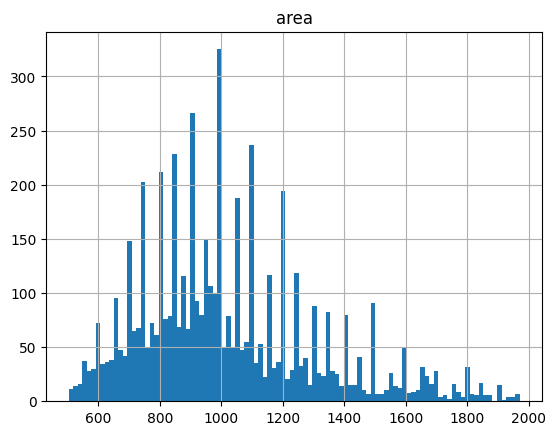

In [250]:
# создать гистограмму с отфильтрованным выбросом
filtered_outliers = data_filtered[['price',"area"]]

for col in filtered_outliers:
    data_filtered.hist(col, bins=100)

**Заключение**:
- у двух полей удалили аномально большие значения, которых меньшинство; таким образом графики стали симметричнее

# Средняя цена за каждый тип жилья

In [251]:
# Создание переменной с типом и средней ценой
avg_price = data_filtered.pivot_table(index='type_of_building', values='price', aggfunc='mean')
avg_price

,price
type_of_building,
Flat,1.990770e+07
Individual House,1.950357e+07


Мы видим, что средние цены у квартиры и отдельного дома +\- одинаковые.

# Ценовые факторы

Основные параметры, влиящие на цену:
- area
- bedrooms
- bathrooms
- balcony
- parking
- lift

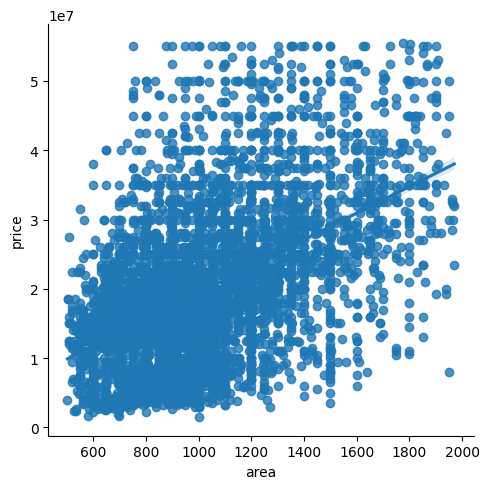

In [252]:
import seaborn as sns
sns.lmplot(x="area", y="price", data= data_filtered)

In [253]:
area = data[['area', 'price']]
corr_area = area.corr()
corr_area

,area,price
area,1.000000,0.712463
price,0.712463,1.000000


In [254]:
for field in ['bathrooms', 'bedrooms', 'balcony', 'parking', 'lift', 'furnished_status']:
    current = data[[field, 'price']]
    print(current.corr())

           bathrooms    price
bathrooms    1.00000  0.63937
price        0.63937  1.00000
          bedrooms     price
bedrooms  1.000000  0.586568
price     0.586568  1.000000
          balcony     price
balcony  1.000000  0.094712
price    0.094712  1.000000
          parking     price
parking  1.000000  0.094712
price    0.094712  1.000000
           lift     price
lift   1.000000  0.094712
price  0.094712  1.000000
                  furnished_status     price
furnished_status          1.000000  0.065681
price                     0.065681  1.000000


Как мы видим, наиболее влияющие на цену факторами являются площадь, кол-во ванных комнат и спален. 

Кол-вол парковочных мест, балконов, лифтов и мебели почти не влияют на цену.

In [255]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5524 entries, 0 to 6236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             5524 non-null   float64
 1   area              5524 non-null   float64
 2   latitude          5524 non-null   float64
 3   longitude         5524 non-null   float64
 4   bedrooms          5524 non-null   int64  
 5   bathrooms         5524 non-null   int64  
 6   balcony           5524 non-null   int64  
 7   status            5524 non-null   bool   
 8   neworold          5524 non-null   bool   
 9   parking           5524 non-null   int64  
 10  furnished_status  5524 non-null   float64
 11  lift              5524 non-null   int64  
 12  type_of_building  5524 non-null   object 
dtypes: bool(2), float64(5), int64(5), object(1)
memory usage: 528.7+ KB


Поскольку цена в среднем очень незначительно отличается от того факта, какой тип жилья - частный дом или квартира - в дальнейшем этот признак нас не особо будет интересовать и мы его дропнем. 

Также нет никакой связи между ценой дома и географич. координатами: широтой, долготой => также дропнем

# Выделение целевого признака. Разбитие выборки.

Целевой признак был известен с самого начала - цена. Разобьем выборку на тестовую и обучающуюся.

In [294]:
y = data_filtered['price']
X = data_filtered.drop(['price', 'type_of_building', 'longitude', 'latitude'], axis=1)

In [257]:
y

0       22400000.0
1       35000000.0
2       31700000.0
3       18700000.0
4       13500000.0
           ...    
6232    19500000.0
6233    22000000.0
6234    20000000.0
6235    11000000.0
6236    15000000.0
Name: price, Length: 5524, dtype: float64

In [295]:
X

,area,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift
0,629.0,2,2,0,False,True,0,0.0,0
1,974.0,3,2,0,False,True,0,0.0,0
2,968.0,3,3,0,False,True,0,0.0,0
3,629.0,2,2,2,True,True,2,0.0,2
4,1090.0,2,2,0,True,True,0,0.0,0
...,...,...,...,...,...,...,...,...,...
6232,810.0,2,2,0,True,False,0,0.5,0
6233,1400.0,3,3,1,True,False,1,0.0,1
6234,750.0,2,2,0,True,False,0,0.0,0
6235,700.0,2,2,0,True,False,0,1.0,0


In [259]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 


<font color=darkviolet size=5>
Simple Linear Regression

In [260]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge


In [303]:
lm = LinearRegression()

x_simple_train = X_train['area'].values.reshape(-1,1)
x_simple_test = X_test['area'].values.reshape(-1,1)


In [ ]:
import numpy as np
np.arange()

*Без регуляризации*

In [304]:
lr = lm.fit(x_simple_train, y_train)


In [305]:
# Печать точки пересечения и коэффициента линейной регрессии
pd.DataFrame([*lm.coef_, lm.intercept_], index=['coefficient', 'intercept'], columns=['Линейная регрессия'])

,Линейная регрессия
coefficient,2.997190e+02
intercept,1.953614e+07


<Axes: ylabel='price'>

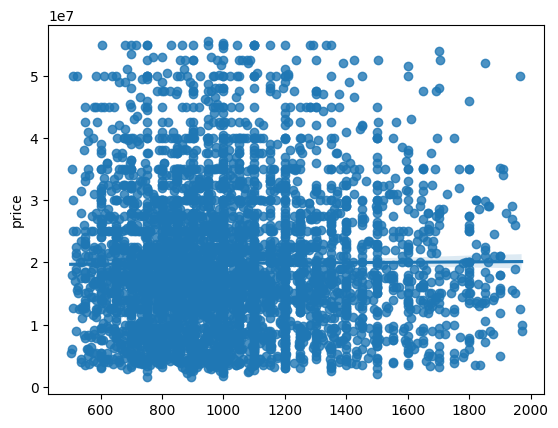

In [306]:
sns.regplot(x = x_simple_train, y = y_train)

In [307]:
# получаем предсказания для тестовой выборки
y_pred = lr.predict(x_simple_test)

In [308]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [309]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lr.score(x_simple_test, y_test)}')

MAE: 8644899.392925218
MSE: 124369301973657.58
RMSE: 11152098.5457293
MAPE: 0.8396208557451642
R^2: 0.0003482910154684049


In [310]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lr.score(x_simple_test, y_test)}')

MAE: 8644899.392925218
MSE: 124369301973657.58
RMSE: 11152098.5457293
MAPE: 0.8396208557451642
R^2: 0.0003482910154684049


*С регуляризацией*

In [311]:
# L1
ridge = Ridge(alpha=0.5).fit(x_simple_train, y_train)
y_pred = ridge.predict(x_simple_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge.score(x_simple_test, y_test)}')
print(f'коэфф: {ridge.coef_}')
print(f'пересеч: {ridge.intercept_}')

MAE: 8644899.392930172
MSE: 124369301973752.56
RMSE: 11152098.54573356
MAPE: 0.839620855745326
R^2: 0.00034829101470501556
коэфф: [299.71899643]
пересеч: 19536143.417849343


In [312]:
# L2
lasso = Lasso(alpha=0.5).fit(x_simple_train, y_train)
y_pred = lasso.predict(x_simple_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge.score(x_simple_test, y_test)}')
print(f'коэфф: {ridge.coef_}')
print(f'пересеч: {ridge.intercept_}')

MAE: 8644899.39299827
MSE: 124369301975057.88
RMSE: 11152098.545792082
MAPE: 0.8396208557475487
R^2: 0.00034829101470501556
коэфф: [299.71899643]
пересеч: 19536143.417849343


<b><font color=green size = 5>**Множественная линейная регрессия**